In [47]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from typing import Callable, Tuple


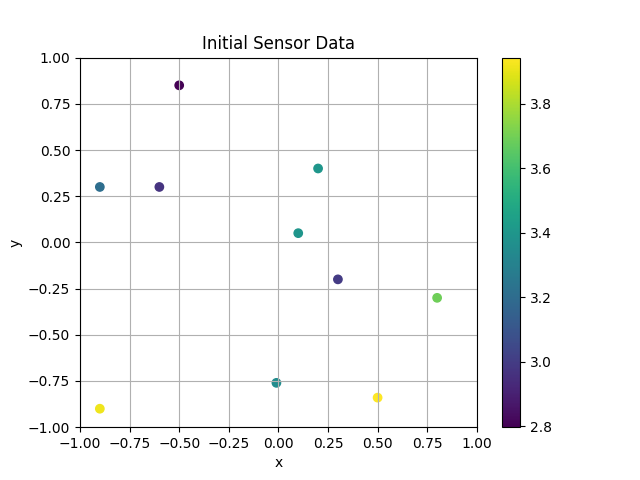

In [48]:
# Table 1: Initial Sensor Data
xdata0 = np.array([
    [0.1, -0.9, 0.2, 0.8, -0.6, 0.3, 0.5, -0.5, -0.01, -0.9],
    [0.05, 0.3, 0.4, -0.3, 0.3, -0.2, -0.84, 0.85, -0.76, -0.9]
])
ydata0 = np.array([
    3.39382006,
    3.2073034,
    3.39965035,
    3.68810201,
    2.96941623,
    2.99495501,
    3.94274928,
    2.7968011,
    3.34929734,
    3.91296165,
])

# visualize the initial data with colors
plt.figure()
plt.scatter(xdata0[0], xdata0[1], c=ydata0)
plt.xlabel('x')
plt.xlim(-1, 1)
plt.ylabel('y')
plt.ylim(-1, 1)
plt.title('Initial Sensor Data')
plt.colorbar()
plt.grid()
plt.show()

In [49]:
# helper functions to run GPR
def sqexp(x: np.ndarray, xp: np.ndarray, tau: np.ndarray = [1, 1], l: np.ndarray = [0.5, 0.5]) -> np.ndarray:
    """Squared exponential kernel (2 dimensional).

    Args:
        x: (2, N) array of multiple inputs in 2D
        xp: (2,) array of the input at which the function values are known for each dimension

    Returns:
        cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    cov0 = tau[0]**2 * np.exp(-1/2 * (x[0] - xp[0])**2 / l[0]**2)
    cov1 = tau[1]**2 * np.exp(-1/2 * (x[1] - xp[1])**2 / l[1]**2)
    return cov0*cov1


def periodic(x: np.ndarray, xp: np.ndarray, tau: np.ndarray = [1, 1], l: np.ndarray = [1, 1], p: np.ndarray = [0.4, 0.4]) -> np.ndarray:
    """Periodic kernel."""
    cov0 = tau[0]**2 * np.exp(-2 * np.sin(np.pi * np.abs(x[0] - xp[0]) / p[0])**2 / l[0]**2)
    cov1 = tau[1]**2 * np.exp(-2 * np.sin(np.pi * np.abs(x[1] - xp[1]) / p[1])**2 / l[1]**2)
    return cov0*cov1


def poly(x: np.ndarray, xp: np.ndarray, c: np.ndarray = [1, 1], d: np.ndarray[int] = [3, 3]):
    """Polynomial kernel."""
    cov0 = (x[0] * xp[0] + c[0])**d[0]
    cov1 = (x[1] * xp[1] + c[1])**d[1]
    return cov0*cov1


kernel_options = {"Sq.Exp": sqexp, "Periodic": periodic, "Poly": poly}


def build_covariance(x: np.ndarray, xp: np.ndarray, kern: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> np.ndarray:
    """Build a covariance matrix.

    Args:
        x: (2,N) array of x-y inputs in 2D
        xp: (2,M) array of x-y inputs in 2D
        kern: a function mapping inputs to covariance

    Outputs:
        cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[1], xp.shape[1]))
    for jj in range(xp.shape[1]):
        # a single x-y data point is stored as a column vector
        out[:, jj] = kern(x, xp[:, jj])
    return out


def gpr(xtrain: np.ndarray,
        ytrain: np.ndarray,
        xpred: np.ndarray,
        noise_var: np.ndarray,
        mean_func: Callable[[np.ndarray], np.ndarray],
        kernel: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    """Gaussian process regression Algorithm.

    Inputs:

        xtrain: (N, ) training inputs
        ytrain: (N, ) training outputs
        xpred:  (M, ) locations at which to make predictions
        noise_var: (N, ) noise at every training output
        mean_func: function to compute the prior mean
        kernel: covariance kernel

    Returns:
        pred_mean: (M, ) predicted mean at prediction points
        pred_cov: (M, M) predicted covariance at the prediction points
    """
    cov = build_covariance(xtrain, xtrain, kernel)
    # u, s, v = np.linalg.svd(cov)
    # sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))

    pred_vec = build_covariance(xpred, xtrain, kernel)
    pred_mean = mean_func(xpred) + np.dot(pred_vec, np.dot(invcov, ytrain - mean_func(xtrain)))

    pred_cov_pre = build_covariance(xpred, xpred, kernel)
    pred_cov_up = np.dot(pred_vec, np.dot(invcov, pred_vec.T))
    pred_cov = pred_cov_pre - pred_cov_up

    return pred_mean, pred_cov


def plot_gpr(mean, cov, xdata, ydata, title):
    num_points = int(len(mean)**(1/2))  # assume square grid

    mesh_x, mesh_y = np.meshgrid(
        np.linspace(-1, 1, num_points), np.linspace(-1, 1, num_points))

    mean_mesh = mean.reshape((num_points, num_points))
    std = 2 * np.sqrt(np.diag(cov))
    std_mesh = std.reshape((num_points, num_points))

    # use separate levels so easier to see
    lmin = min(np.min(mean), np.min(ydata))
    lmax = max(np.max(mean), np.max(ydata))
    levels = np.linspace(lmin, lmax, 10)

    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    fig.tight_layout(pad=3)
    fig.suptitle(title, fontsize=14)

    # plot mean
    ax[0].contourf(mesh_x, mesh_y, mean_mesh, levels=levels)
    ax[0].scatter(xdata[0], xdata[1], c=ydata, vmin=lmin, vmax=lmax,
                  edgecolors='m', label='Sensor Data')
    ax[0].set_title('Mean')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].legend()
    fig.colorbar(ax[0].collections[0], ax=ax[0], format='%.1f')

    # plot std
    ax[1].contourf(mesh_x, mesh_y, std_mesh)
    ax[1].plot(xdata[0], xdata[1], 'm.', markersize=2, label='Sensor Data')
    ax[1].set_title(r'2$\sigma$')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].legend()
    fig.colorbar(ax[1].collections[0], ax=ax[1], format='%.1e')

    plt.show()

In [50]:
# define prior stuff that probably wont change

def meanf(x):
    # prior mean function, just use the mean of the data
    return np.mean(ydata0) * np.ones((x.shape[1]))


# covariance of noise for each data point
NOISE = 1e-2
noise_cov = NOISE * np.ones(xdata0.shape[1])

NUM_POINTS = 50
xpred = np.zeros((2, NUM_POINTS*NUM_POINTS))
for i in range(NUM_POINTS):
    xpred[0, i*NUM_POINTS:(i+1)*NUM_POINTS] = np.linspace(-1, 1, NUM_POINTS)
    xpred[1, i*NUM_POINTS:(i+1)*NUM_POINTS] = np.linspace(-1, 1, NUM_POINTS)[i]


# covariance kernels
# periodic exponential kernel DIDNT USE, COS DATA DOESNT SEEM PERIODIC
# tau = [1, 1]
# l = [1, 1]
# p = [0.4, 0.4]
# def kernel(x, xp): return kernel_options["Periodic"](x, xp, tau=tau, l=l, p=p)


# squared exponential kernel
tau = [1, 1]
l = [0.2, 0.2]
def kernel(x, xp): return kernel_options["Sq.Exp"](x, xp, tau=tau, l=l)


# polynomial kernel
# c = [1, 1]
# d = [3, 3]
# def kernel(x, xp): return kernel_options["Poly"](x, xp, c=c, d=d)

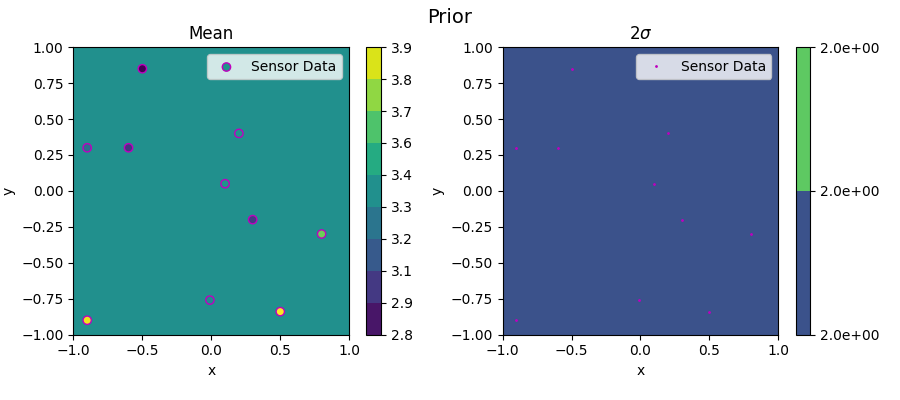

In [51]:
# build prior
prior_mean = meanf(xpred)
prior_cov = build_covariance(xpred, xpred, kernel)
plot_gpr(prior_mean, prior_cov, xdata0, ydata0, 'Prior')

Poly global: Best c: 0.22, Best d: 2.00, likelihood: -7.02


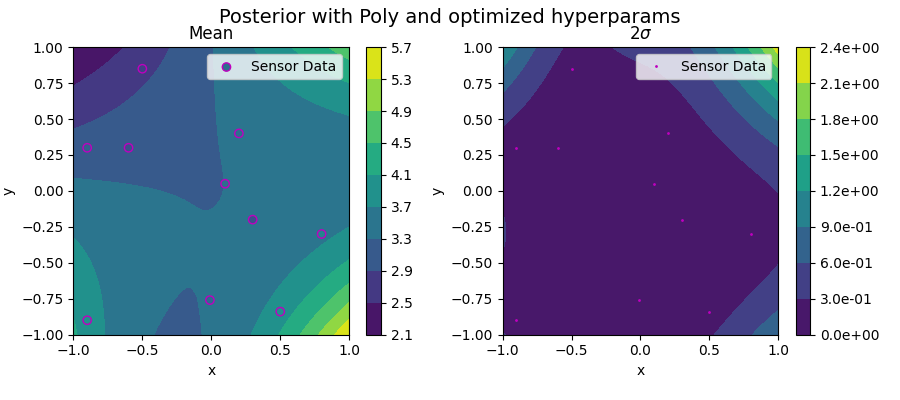

In [52]:
# tune hyperparams by maximizing likelihood because useful in low data regime

def log_likelihood(xdata, ydata, noise_cov, kernel):
    cov = build_covariance(xdata, xdata, kernel) + np.diag(noise_cov)
    invcov = np.linalg.pinv(cov)
    ydata = ydata - meanf(xdata)
    log_likelihood = -0.5 * (np.dot(ydata, np.dot(invcov, ydata)) +
                             np.linalg.slogdet(cov).logabsdet + len(ydata) * np.log(2 * np.pi))
    return log_likelihood


# using shitty global search instead of scipy cos d needs to be an int
likelihood = -np.inf
cs = np.linspace(0.1, 0.3, 100)
ds = range(1, 3)
po_c = 0
po_d = 0
for c in cs:
    for d in ds:
        def kernel(x, xp): return kernel_options["Poly"](x, xp, c=[c, c], d=[d, d])
        lk = log_likelihood(xdata0, ydata0, noise_cov, kernel)
        if lk > likelihood:
            likelihood = lk
            po_c = c
            po_d = d

print(f'Poly global: Best c: {po_c:.2f}, Best d: {po_d:.2f}, likelihood: {likelihood:.2f}')


def kernel(x, xp):
    return kernel_options["Poly"](x, xp, c=[po_c, po_c], d=[po_d, po_d])


pred_mean, pred_cov = gpr(xdata0, ydata0, xpred, noise_cov, meanf, kernel)
plot_gpr(pred_mean, pred_cov, xdata0, ydata0, 'Posterior with Poly and optimized hyperparams')

Sq.Exp scipy: Best tau: 0.60, Best l: -0.27, likelihood: -4.07


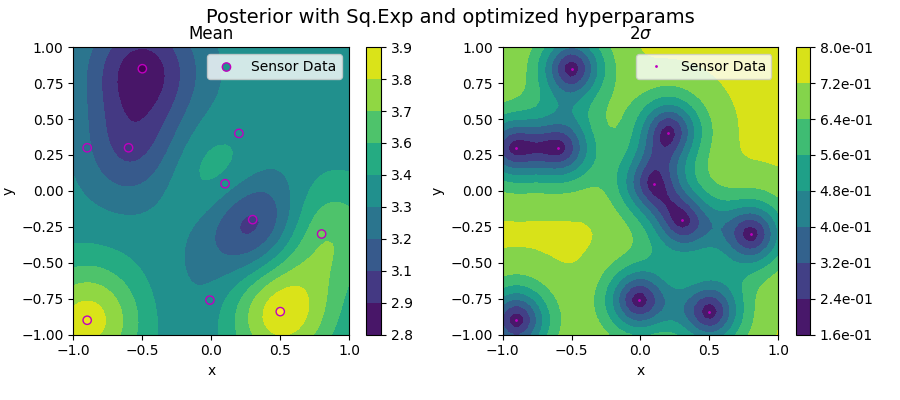

In [53]:

def opt_sqexp(input):
    tau = input[0]
    l = input[1]
    def kernel(x, xp): return kernel_options["Sq.Exp"](x, xp, tau=[tau, tau], l=[l, l])
    return -log_likelihood(xdata0, ydata0, noise_cov, kernel)


opt = minimize(opt_sqexp, [1, 1])
# xopt = minimize(opt_sqexp, [0.1, 0.1])
opt_tau = opt.x[0]
opt_l = opt.x[1]
print(
    f'Sq.Exp scipy: Best tau: {opt_tau:.2f}, Best l: {opt_l:.2f}, likelihood: {-opt.fun:.2f}')


def kernel(x, xp):
    return kernel_options["Sq.Exp"](x, xp, tau=[opt_tau, opt_tau], l=[opt_l, opt_l])


pred_mean, pred_cov = gpr(xdata0, ydata0, xpred, noise_cov, meanf, kernel)
plot_gpr(pred_mean, pred_cov, xdata0, ydata0, 'Posterior with Sq.Exp and optimized hyperparams')

Periodic Scipy: Best tau: 0.60, Best l: 0.02, Best p: 82.28, likelihood: -4.07


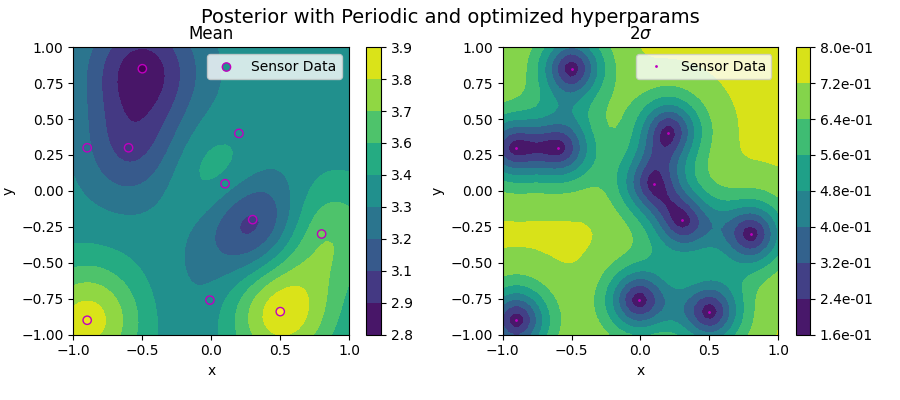

In [54]:
# likelihood = -np.inf
# taus = np.linspace(0.1, 1, 20)
# ls = np.linspace(0.01, 0.10, 20)
# ps = np.linspace(70, 100, 50)
# pe_tau = 0
# pe_l = 0
# pe_p = 0
# for tau in taus:
#     for l in ls:
#         for p in ps:
#             def kernel(x, xp): return kernel_options["Periodic"](
#                 x, xp, tau=[tau, tau], l=[l, l], p=[p, p])
#             lk = log_likelihood(xdata, ydata, noise_cov, kernel)
#             if lk > likelihood:
#                 likelihood = lk
#                 pe_tau = tau
#                 pe_l = l
#                 pe_p = p

# print(
#     f'Periodic global: Best tau: {pe_tau:.2f}, Best l: {pe_l:.2f}, Best p: {pe_p:.2f}, likelihood: {likelihood:.2f}')


def opt_periodic(input):
    tau = input[0]
    l = input[1]
    p = input[2]
    def kernel(x, xp): return kernel_options["Periodic"](x, xp, tau=[tau, tau], l=[l, l], p=[p, p])
    return -log_likelihood(xdata0, ydata0, noise_cov, kernel)


opt = minimize(opt_periodic, [1, 1, 1])
# xopt = minimize(opt_periodic, [5, 0.5, 1.4])
# xopt = minimize(opt_periodic, [50,50,50])
print(
    f'Periodic Scipy: Best tau: {opt.x[0]:.2f}, Best l: {opt.x[1]:.2f}, Best p: {opt.x[2]:.2f}, likelihood: {-opt.fun:.2f}')

# use scipy's cos likelihood is higher

# 5.12, Best per_l: 0.49, Best per_p: 1.42


def kernel(x, xp):
    # return kernel_options["Periodic"](x, xp, tau=[5.12,5.12], l=[0.49,0.49], p=[1.42,1.42])
    return kernel_options["Periodic"](x, xp, tau=[opt.x[0], opt.x[0]], l=[opt.x[1], opt.x[1]], p=[opt.x[2], opt.x[2]])


pred_mean, pred_cov = gpr(xdata0, ydata0, xpred, noise_cov, meanf, kernel)
plot_gpr(pred_mean, pred_cov, xdata0, ydata0, 'Posterior with Periodic and optimized hyperparams')

Combined Scipy: Best exp_tau: 0.77, Best exp_l: 0.75, Best per_tau: 0.77, Best per_l: 0.82, Best per_p: 0.94, likelihood: -4.25


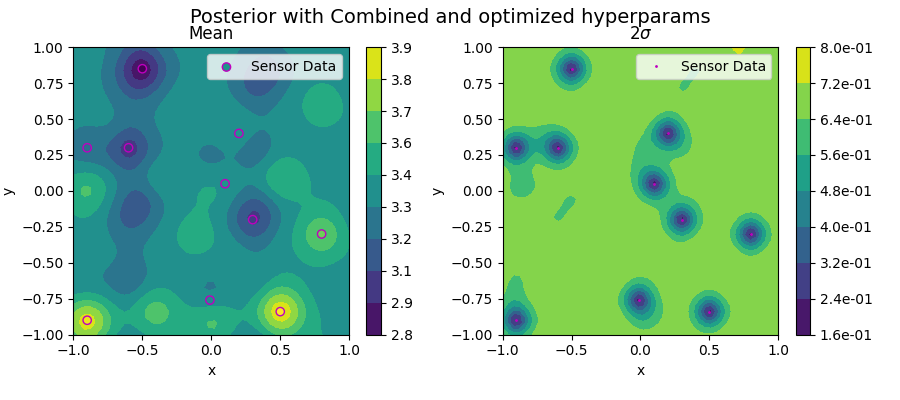

In [55]:
# sqexp and periodic are the best, so combine then and use sciy to optimize

def opt_combined(input):
    exp_tau = input[0]
    exp_l = input[1]
    per_tau = input[2]
    per_l = input[3]
    per_p = input[4]

    def kernel(x, xp):
        k1 = kernel_options["Sq.Exp"](x, xp, tau=[exp_tau, exp_tau], l=[exp_l, exp_l])
        k2 = kernel_options["Periodic"](x, xp, tau=[per_tau, per_tau], l=[
                                        per_l, per_l], p=[per_p, per_p])
        return k1*k2
    return -log_likelihood(xdata0, ydata0, noise_cov, kernel)


# xopt = minimize(opt_combined, [0.1, 0.1, 1, 1, 1])
opt = minimize(opt_combined, [1, 1, 1, 1, 1])
print(
    f'Combined Scipy: Best exp_tau: {opt.x[0]:.2f}, Best exp_l: {opt.x[1]:.2f}, Best per_tau: {opt.x[2]:.2f}, Best per_l: {opt.x[3]:.2f}, Best per_p: {opt.x[4]:.2f}, likelihood: {-opt.fun:.2f}')
# print(xopt)


def kernel(x, xp):
    k1 = kernel_options["Sq.Exp"](x, xp, tau=[opt.x[0], opt.x[0]], l=[
                                  opt.x[1], opt.x[1]])
    k2 = kernel_options["Periodic"](x, xp, tau=[opt.x[2], opt.x[2]], l=[
                                    opt.x[3], opt.x[3]], p=[opt.x[4], opt.x[4]])
    return k1*k2


pred_mean, pred_cov = gpr(xdata0, ydata0, xpred, noise_cov, meanf, kernel)
plot_gpr(pred_mean, pred_cov, xdata0, ydata0, 'Posterior with Combined and optimized hyperparams')

In [ ]:
# verify the plot using the optimal kernel
def kernel(x, xp):
    return kernel_options["Sq.Exp"](x, xp, tau=[opt_tau, opt_tau], l=[opt_l, opt_l])


pred_mean, pred_cov = gpr(xdata0, ydata0, xpred, noise_cov, meanf, kernel)
plot_gpr(pred_mean, pred_cov, xdata0, ydata0, 'Posterior with best hyperparams')
print(f'Data variance: {(np.var(ydata0))}')
pred_var = np.diag(pred_cov)
print(f'Max Posterior variance: {np.max(pred_var)}')

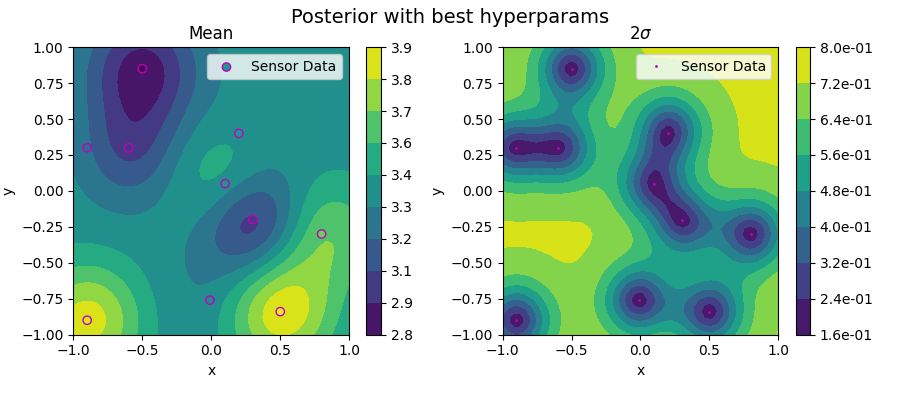

Data variance: 0.13818643899977315
Max Posterior variance: 0.13339732122697248
New points:f 136
[[-0.55102041  0.71428571  0.75510204  0.02040816]
 [-0.34693878  0.63265306  0.14285714  0.79591837]]


In [59]:
# Acquisition function
def acquire_reduce_var(kernel, xdata, ydata, xpred, new_pts):
    noise_cov = NOISE * np.ones(xdata.shape[1])
    pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, kernel)
    pred_cov_best = pred_cov.copy()
    xdata_aug = xdata.copy()
    ydata_aug = ydata.copy()
    for i in range(new_pts):
        # threshold the current uncertainty to get the viable points
        pred_var_temp = np.diag(pred_cov_best)
        pred_var_tot = np.sum(pred_var_temp)
        pred_var_max = np.max(pred_var_temp)
        var_thresh = 0.9*pred_var_max
        pred_var_thresh = pred_var_temp > var_thresh
        viable_x = xpred[:, pred_var_thresh]
        viable_y = pred_mean[pred_var_thresh]
        var_red_max = 0
        var_red_max_idx = 0
        # iterate through the viable points but skip every other one to reduce computation cost
        for pt_idx in range(0, len(viable_y), 2):
            print(f'Point {pt_idx+1} of {len(viable_y)}', end='\r')
            # add the point to the dataset with pred_mean as the value at that point
            xdata_temp = np.hstack((xdata_aug, viable_x[:, pt_idx].reshape(2, 1)))
            ydata_temp = np.append(ydata_aug, viable_y[pt_idx])
            # compute the new pred_var
            noise_cov_temp = NOISE * np.ones(xdata_temp.shape[1])
            _, pred_cov_temp = gpr(xdata_temp, ydata_temp, xpred, noise_cov_temp, meanf, kernel)
            # compute the new total uncertainty
            var_red = pred_var_tot - np.sum(np.diag(pred_cov_temp))
            if var_red > var_red_max:
                var_red_max = var_red
                var_red_max_idx = pt_idx
                pred_cov_best = pred_cov_temp

        xdata_aug = np.hstack((xdata_aug, viable_x[:, var_red_max_idx].reshape(2, 1)))
        ydata_aug = np.append(ydata_aug, viable_y[var_red_max_idx])
    return xdata_aug[:, -new_pts:]


NUM_NEW_PTS_REDVAR = 4
new_xpts = acquire_reduce_var(kernel, xdata0, ydata0, xpred, NUM_NEW_PTS_REDVAR)
print(f'New points:\n{new_xpts}')

Sq.Exp scipy: Best tau: 0.69, Best l: -0.28, likelihood: -9.24


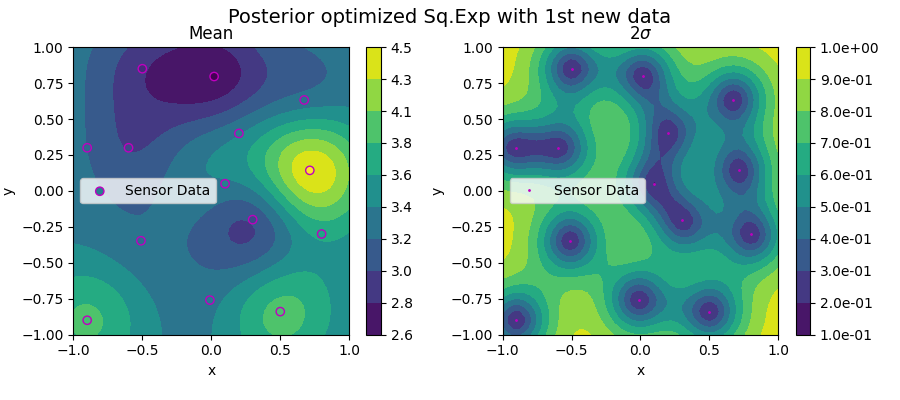

In [41]:
# optimise the kernel with new data and plot the posterior
xdata_new1 = [
    [
        -5.102040799999999487e-01,
        6.734693899999999456e-01,
        7.142857099999999626e-01,
        2.040816000000000158e-02],
    [
        -3.469387800000000022e-01,
        6.326530599999999893e-01,
        1.428571399999999936e-01,
        7.959183699999999861e-01,
    ]
]
ydata_new1 = [
    3.249887528688572669e+00,
    3.278017251997401349e+00,
    4.480098976113844778e+00,
    2.572843029623550493e+00,
]
xdata1 = np.hstack((xdata0, xdata_new1))
ydata1 = np.append(ydata0, ydata_new1)

# xdata1 = xdata0
# ydata1 = ydata0

noise_cov1 = NOISE * np.ones(xdata1.shape[1])


def opt_sqexp1(input):
    tau = input[0]
    l = input[1]
    def kernel(x, xp): return kernel_options["Sq.Exp"](x, xp, tau=[tau, tau], l=[l, l])
    return -log_likelihood(xdata1, ydata1, noise_cov1, kernel)


opt1 = minimize(opt_sqexp1, [1, 1])
opt_tau1 = opt1.x[0]
opt_l1 = opt1.x[1]

print(
    f'Sq.Exp scipy: Best tau: {opt_tau1:.2f}, Best l: {opt_l1:.2f}, likelihood: {-opt1.fun:.2f}')


def kernel(x, xp):
    return kernel_options["Sq.Exp"](x, xp, tau=[opt_tau1, opt_tau1], l=[opt_l1, opt_l1])


pred_mean1, pred_cov1 = gpr(xdata1, ydata1, xpred, noise_cov1, meanf, kernel)
plot_gpr(pred_mean1, pred_cov1, xdata1, ydata1, 'Posterior optimized Sq.Exp with 1st new data')

In [61]:
# new acquision function expected improvement
def max_expected_improvement(pred_mean, pred_std, ymax):
    # normalize
    z = (pred_mean - ymax) / pred_std
    # return id of max expected improvement
    return np.argmax(pred_std * (z * norm.cdf(z) + norm.pdf(z)))


def acquire_max_ei(kernel, xdata, ydata, xpred, new_pts):
    noise_cov = NOISE * np.ones(xdata.shape[1])
    pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, kernel)
    pred_cov_temp = pred_cov.copy()
    pred_mean_temp = pred_mean.copy()
    xdata_aug = xdata.copy()
    ydata_aug = ydata.copy()
    for i in range(new_pts):
        pred_std_temp = np.sqrt(np.diag(pred_cov_temp))
        idx_max_ei = max_expected_improvement(pred_mean_temp, pred_std_temp, np.max(ydata_aug))

        xdata_aug = np.hstack((xdata_aug, xpred[:, idx_max_ei].reshape(2, 1)))
        ydata_aug = np.append(ydata_aug, pred_mean[idx_max_ei])
        noise_cov_temp = NOISE * np.ones(xdata_aug.shape[1])
        pred_mean_temp, pred_cov_temp = gpr(
            xdata_aug, ydata_aug, xpred, noise_cov_temp, meanf, kernel)
        # threshold the current uncertainty to get the viable points
        # pred_var_temp = np.diag(pred_cov_best)
        # pred_var_tot = np.sum(pred_var_temp)
        # pred_var_max = np.max(pred_var_temp)
        # var_thresh = 0.9*pred_var_max
        # pred_var_thresh = pred_var_temp > var_thresh
        # viable_x = xpred[:, pred_var_thresh]
        # viable_y = pred_mean[pred_var_thresh]
        # var_red_max = 0
        # var_red_max_idx = 0
        # iterate through the viable points but skip every other one to reduce computation cost
        # for pt_idx in range(0, len(viable_y), 2):
        #     print(f'Point {pt_idx+1} of {len(viable_y)}', end='\r')
        #     # add the point to the dataset with pred_mean as the value at that point
        #     xdata_temp = np.hstack((xdata_aug, viable_x[:, pt_idx].reshape(2, 1)))
        #     ydata_temp = np.append(ydata_aug, viable_y[pt_idx])
        #     # compute the new pred_var
        #     noise_cov_temp = NOISE * np.ones(xdata_temp.shape[1])
        #     _, pred_cov_temp = gpr(xdata_temp, ydata_temp, xpred, noise_cov_temp, meanf, kernel)
        #     # compute the new total uncertainty
        #     var_red = pred_var_tot - np.sum(np.diag(pred_cov_temp))
        #     if var_red > var_red_max:
        #         var_red_max = var_red
        #         var_red_max_idx = pt_idx
        #         pred_cov_best = pred_cov_temp

        # xdata_aug = np.hstack((xdata_aug, viable_x[:, var_red_max_idx].reshape(2, 1)))
        # ydata_aug = np.append(ydata_aug, viable_y[var_red_max_idx])
    return xdata_aug[:, -new_pts:]


pred_std1 = np.sqrt(np.diag(pred_cov1))
idx_max_ei = max_expected_improvement(pred_mean1, pred_std1, np.max(pred_mean1))
print(f'Max expected improvement at {xpred[:, idx_max_ei]}')

Expected improvement at [0.83673469 0.14285714]
